In [199]:
#Imports
import numpy as np
import h5py as h5
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 12

In [200]:
#datasets
data_path = '/projects/nikhil/ADNI_prediction/input_datasets/'

#input data
train_val_file = data_path + 'cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/francisco/data/ADNI/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = data_path + 'cli_ct_train_valid_KFold_idx.pkl'


In [201]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scale])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])

    var_names = data_trunc.filter(regex=all_vars).columns
    
    # Return train and validation lists comprising all folds
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}, var_names

#Load test data
def load_test_data(in_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scale])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    return {'X':X, 'y':y}
    

In [202]:
feature_cols = ['CT', 'L_HC_VOL','R_HC_VOL']
clinical_scale = ['ADAS13_bl']

cv_data, var_names = load_CV_data(train_val_file,kf_file, clinical_scale, feature_cols)
test_data = load_test_data(test_file, clinical_scale, feature_cols)
print cv_data['X_train'][0].shape

(522, 76)


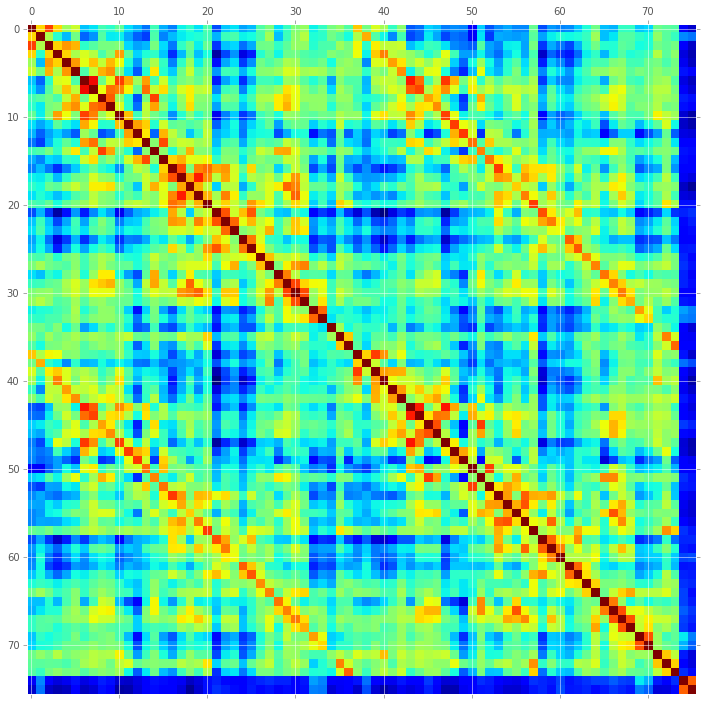

In [203]:
# Correlation matrix
data = pd.read_pickle(train_val_file)
all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
data_trunc = data.filter(regex=all_vars)
data_trunc = data_trunc.dropna(how='any')

plt.matshow(data_trunc.corr())




In [223]:
# Define a model

# The two independent vars are highly correlated, so an ordinary least squares regression may
# be the best idea: the model will be highly sensitive to random errors in the response var. See 
# https://en.wikipedia.org/wiki/Multicollinearity

# Space for hyperparam search
alphas=np.logspace(-5,5,num=100)

# We can instead try a ridge regression:
from sklearn import linear_model
from sklearn.metrics import r2_score
BaseReg=linear_model.RidgeCV
    
class Regression(BaseReg):
    def __init__(self, *args, **kwargs):
        super(Regression, self).__init__(*args,**kwargs)
    

    def fit(self, X, y):
        self = super(Regression, self).fit(X,y)
        df = X.shape[0] - X.shape[1] - 1
        y_hat = self.predict(X)
        sse = np.sum(np.square(y - y_hat), axis=0)
        self.variance_y = sse/df
        self.variance_X = (np.matrix(X).T * np.matrix(X)).I
        self.zscores_ = self.coef_ / np.sqrt(self.variance_y * self.variance_X.diagonal())
        self.pvals_ = 1 - scipy.stats.t.cdf(abs(self.zscores_), df)
    
    def score(self, X, y):
        N, P = X.shape
        y_hat = self.predict(X)
        
        # R2 and adjusted R2:
        self.R2 = r2_score(y, y_hat)
        self.rmse = np.sqrt(mean_squared_error(y, y_hat))
        self.adj_R2 = self.R2 - (1 - self.R2) * ((N - 1) / (N - P - 1))
        
        self.var_y = np.var(y)
        
        self.ssm = np.sum(np.square(y_hat - y.mean()))
        self.sse = np.sum(np.square(y - y_hat))
        self.sst = np.sum(np.square(y - y.mean()))
        self.r = scipy.stats.pearsonr(y, y_hat)
        
        return self.R2
        

if BaseReg==linear_model.RidgeCV:
    reg = Regression(alphas=alphas, normalize=False, fit_intercept=True)
else:
    reg = Regression(normalize=False, fit_intercept=True)

In [224]:
X = cv_data['X_valid'][0]
N, P = X.shape
print N, P


59 76


In [226]:
from sklearn.metrics import mean_squared_error, r2_score
import sklearn

# Cross-validation loop
stats = []
coefs = []
alphas = []
zscores = []
pvals = []

for fold in range(len(cv_data['X_train'])):
    X = cv_data['X_train'][fold]
    y = cv_data['y_train'][fold].ravel()
    X_v = cv_data['X_valid'][fold]
    y_v = cv_data['y_valid'][fold].ravel()
    print y.shape
    
    # Normalize each feature individually:
    #X = sklearn.preprocessing.normalize(X, axis=0)
    #X_v = sklearn.preprocessing.normalize(X_v, axis=0)
    
    reg.fit(X, y)
    y_hat = reg.predict(X)
    # validation:
    y_hat_v = reg.predict(X_v)
    mse = mean_squared_error(y_v, y_hat_v)
    reg.score(X_v, y_v)
    stats.append((reg.R2, reg.adj_R2, reg.rmse, reg.r[0], reg.r[1]))
    
    try:
        alphas.append(reg.alpha_)
    except:
        pass
    coefs.append(reg.coef_)
    zscores.append(reg.zscores_)
    pvals.append(reg.pvals_)
    

(522,)
(523,)
(523,)
(523,)
(523,)
(523,)
(523,)
(523,)
(523,)
(523,)


In [227]:
def make_table(k, var_names, **kwargs):
    header_mean = ['Mean {}'.format(key) for key in kwargs.keys()]
    header_std = ['Std {}'.format(key) for key in kwargs.keys()]
    header = header_mean + header_std
    header[::2]=header_mean
    header[1::2]=header_std
    header = ['Variables'] + header
    table = np.zeros(shape=(len(var_names),2 * len(kwargs.keys())))
    for i, stat in enumerate(kwargs.values()):
        M=stat.reshape(k,-1).T
        table[:, i*2] = np.mean(M,axis=1)
        table[:, (i*2)+1] = np.std(M,axis=1)
    
    frame = pd.DataFrame(table)
    frame.insert(0, 'Variable', var_names)
    frame.columns = header
    return frame

In [228]:
from IPython.display import display

stats = np.array(stats)
coefs = np.array(coefs)
alphas = np.array(alphas)
zscores = np.array(zscores)
pvals = np.array(pvals)
alpha=scipy.stats.mode(alphas)[0][0]
print 'Mode of regularization param: {}'.format(alpha)

model=make_table(10, ['Model'], R2=stats[:,0], Adj_R2=stats[:,1], RMSE=stats[:,2], r=stats[:,3], pval=stats[:,4])
display(model)
table = make_table(10, var_names, coefs=coefs, zscores=zscores, pvals=pvals)
table=table.sort(['Mean pvals'], ascending=[1])
display(table)




Mode of regularization param: 14.508287785


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,2.557665,0.172165,0.000168,0.000321,0.526818,0.062833,0.254125,0.05789,7.577725,0.685921


,Variables,Mean zscores,Std zscores,Mean pvals,Std pvals,Mean coefs,Std coefs
75,R_HC_VOL,-2.987600,0.259366,0.002149,0.002522,-0.006096,0.000573
69,CT_TPOsup.R,-1.281954,0.095495,0.101272,0.016162,-3.260251,0.230579
32,CT_TPOsup.L,-1.076118,0.132418,0.143328,0.029914,-2.343544,0.269961
36,CT_PCG.L,-0.938170,0.196069,0.178894,0.049955,-2.601367,0.517582
12,CT_PCL.L,0.726181,0.074730,0.234671,0.023099,2.093185,0.215425
48,CT_SMA.R,0.700964,0.078367,0.242510,0.024716,2.004124,0.202288
73,CT_PCG.R,-0.658212,0.075522,0.255968,0.024445,-1.792481,0.208046
17,CT_IPL.L,-0.578979,0.082271,0.282135,0.026704,-2.706461,0.358377
71,CT_ACG.R,0.571262,0.160793,0.286524,0.054393,1.780251,0.497147
19,CT_ANG.L,-0.554100,0.069352,0.290358,0.023342,-2.043106,0.242177


In [229]:
from sklearn.linear_model import Ridge

# Fit final model for testing
X = np.concatenate([cv_data['X_train'][0], cv_data['X_valid'][0]], axis=0)
y = np.concatenate([cv_data['y_train'][0], cv_data['y_valid'][0]], axis=0)
print X.shape
print y.shape

if BaseReg==linear_model.RidgeCV:
    test_reg = Ridge(alpha=alpha, normalize=False, fit_intercept=True)
else:
    test_reg = Regression(normalize=False, fit_intercept=True)
    
test_reg.fit(X,y)

(581, 76)
(581, 1)


Ridge(alpha=14.508287784959402, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, solver='auto', tol=0.001)

In [230]:
X_t = test_data['X']
y_t = test_data['y']
print X_t.shape
print y_t.shape
y_hat_t=test_reg.predict(X_t)
R2 = r2_score(y_t, y_hat_t)
r = scipy.stats.pearsonr(y_t, y_hat_t)
rmse = np.sqrt(mean_squared_error(y_t, y_hat_t))
print rmse

(110, 76)
(110, 1)
7.96778478206


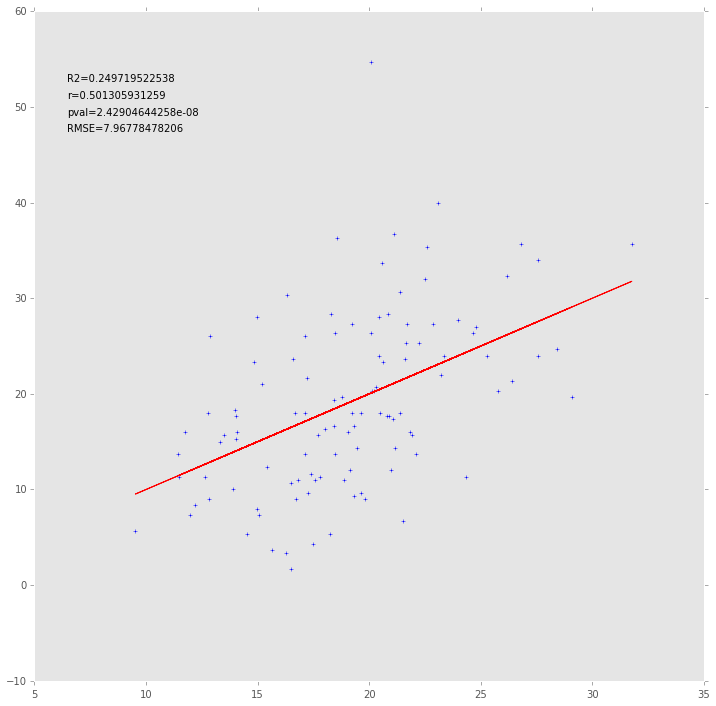

In [231]:
ax=plt.subplot(1,1,1)
plt.scatter(y_hat_t, y_t, marker='+', color='blue')
plt.plot(y_hat_t, y_hat_t, color='red', linewidth=1)
plt.text(0.05, 0.9,'R2={}'.format(R2), horizontalalignment='left', verticalalignment='center', transform = ax.transAxes)
plt.text(0.05, 0.875,'r={}'.format(r[0][0]), horizontalalignment='left', verticalalignment='center', transform = ax.transAxes)
plt.text(0.05, 0.85,'pval={}'.format(r[1][0]), horizontalalignment='left', verticalalignment='center', transform = ax.transAxes)
plt.text(0.05, 0.825,'RMSE={}'.format(rmse), horizontalalignment='left', verticalalignment='center', transform = ax.transAxes)
plt.grid()    
plt.show()